# GBM Notices analysis

First we download all notices we can from the Fermi-GBM main topics in VOEvent format, through Kafka.
The script I used is the following:

```python
from gcn_kafka import Consumer
from pathlib import Path

|
def consumer_set_subscriptions(consumer: Consumer):
    consumer.subscribe([
        'gcn.classic.voevent.FERMI_GBM_ALERT',
        'gcn.classic.voevent.FERMI_GBM_FIN_POS',
        'gcn.classic.voevent.FERMI_GBM_FLT_POS',
        'gcn.classic.voevent.FERMI_GBM_GND_POS',
    ])


if __name__=="__main__":
    consumer = Consumer(
        client_id="CLIENT-ID",
        client_secret="SECRET-KEY",
        config={
            "auto.offset.reset": "earliest",
        },
    )
    consumer_set_subscriptions(consumer)

    while True:
        for message in consumer.consume(timeout=1):
            if message.error():
                print(message.error())
                continue
            topic = message.topic().split('.')[-1].lower()
            offset_str = str(message.offset())
            fpath = Path(__file__).parent / f"notices/voe_{topic}_{offset_str}.xml"
            with open(fpath, "w") as f:
                f.write(message.value().decode())
            print(f"Saved one VOEvent (topic={topic}, offset={offset_str}) to {fpath.name}")
```

The notices are stored with name formatted as `voe_{topic}_{offset_str}.xml` in the `notices` directory.

## VOEvent parsing - XML to dict

To analyze the notices we got we need first to parse the VOEvent XML files into manageable python objects. 
There is a library for this already but it ain't installing for some reason my office desktop.
Luckily, python provides a standard library module `xml` which parses a XML file into a tree.
However dealing with this data structure is a bit unhandy. 
To taper with this we will wrote a function to traverse the xml tree and compose a nested dictionary from its content.

Let's start with a single notice. We choose one notice at random, read it from file, and parse the XML tree with `xml`.

In [1]:
from pathlib import Path
import re
import random; random.seed(10)
from random import choice
import xml.etree.ElementTree as ET


NOTICES_PATH = Path("/home/deppep/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices")
# NOTICES_PATH = Path("/Users/peppedilillo/Library/CloudStorage/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices")
FILENAME_PATTERN = r"voe_(.*?)_(\d+).xml"

events = {}
for file in NOTICES_PATH.iterdir():
    if not (match := re.match(FILENAME_PATTERN, file.name)):
        print(f"Cannot match {file.name}"); continue
    topic, offset = match.groups()
    events.setdefault(topic, []).append(int(offset))


topic = "fermi_gbm_gnd_pos"
voe_random = NOTICES_PATH / f"voe_{topic}_{choice(events[topic])}.xml"
print(voe_random)
xml_voe = ET.parse(voe_random)

print(f"Selected notice '{voe_random.name}'.")

/home/deppep/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices/voe_fermi_gbm_gnd_pos_1015.xml
Selected notice 'voe_fermi_gbm_gnd_pos_1015.xml'.


Print the file's content for reference:

In [2]:
with open(voe_random) as f:
    print(f.read())

<?xml version = '1.0' encoding = 'UTF-8'?>
<voe:VOEvent
      ivorn="ivo://nasa.gsfc.gcn/Fermi#GBM_Gnd_Pos_2025-02-26T22:30:23.12_762301828_58-825"
      role="observation" version="2.0"
      xmlns:voe="http://www.ivoa.net/xml/VOEvent/v2.0"
      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
      xsi:schemaLocation="http://www.ivoa.net/xml/VOEvent/v2.0  http://www.ivoa.net/xml/VOEvent/VOEvent-v2.0.xsd" >
  <Who>
    <AuthorIVORN>ivo://nasa.gsfc.tan/gcn</AuthorIVORN>
    <Author>
      <shortName>Fermi (via VO-GCN)</shortName>
      <contactName>Julie McEnery</contactName>
      <contactPhone>+1-301-286-1632</contactPhone>
      <contactEmail>Julie.E.McEnery@nasa.gov</contactEmail>
    </Author>
    <Date>2025-02-26T22:31:10</Date>
    <Description>This VOEvent message was created with GCN VOE version: 15.08 17jun22</Description>
  </Who>
  <What>
    <Param name="Packet_Type"           value="112" />
    <Param name="Pkt_Ser_Num"           value="51" />
    <Param name="TrigI

Now we write a DFS parser transforming the XML tree into a nested dictionary. 

In [3]:
from typing import NamedTuple

def safe_put(k, v, d):
    if k in d:
        if not isinstance(d[k], list):
            d[k] = [d[k]]
        d[k].append(v)
    else:
        d[k] = v

def parse_tree(node: ET) -> dict:
    def visit(node):
        k, v = node.tag, {}
        v.update(**{f"@{k_}": v_ for k_, v_ in node.attrib.items()})    
        if node.text is None:
            return k, v
        if not node.text.strip():
            return k, v
        v["#text"] = node.text 
        return k, v
    
    def dfs(node, out):
        if node is None:
            return
        k, v = visit(node)
        safe_put(k, v, out)
        for child in node:
            dfs(child, v)

    out = {}
    dfs(node, out)
    return out

def parse_notice(filepath: str | Path) -> dict:
    root = ET.parse(filepath).getroot()
    out = {}
    out.update(parse_tree(root))
    assert len(out) == 1
    return out.pop(*out.keys())

The parser output on the random VOE:

In [4]:
out = parse_notice(voe_random)
out

{'@ivorn': 'ivo://nasa.gsfc.gcn/Fermi#GBM_Gnd_Pos_2025-02-26T22:30:23.12_762301828_58-825',
 '@role': 'observation',
 '@version': '2.0',
 '@{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://www.ivoa.net/xml/VOEvent/v2.0  http://www.ivoa.net/xml/VOEvent/VOEvent-v2.0.xsd',
 'Who': {'AuthorIVORN': {'#text': 'ivo://nasa.gsfc.tan/gcn'},
  'Author': {'shortName': {'#text': 'Fermi (via VO-GCN)'},
   'contactName': {'#text': 'Julie McEnery'},
   'contactPhone': {'#text': '+1-301-286-1632'},
   'contactEmail': {'#text': 'Julie.E.McEnery@nasa.gov'}},
  'Date': {'#text': '2025-02-26T22:31:10'},
  'Description': {'#text': 'This VOEvent message was created with GCN VOE version: 15.08 17jun22'}},
 'What': {'Param': [{'@name': 'Packet_Type', '@value': '112'},
   {'@name': 'Pkt_Ser_Num', '@value': '51'},
   {'@name': 'TrigID', '@value': '762301828', '@ucd': 'meta.id'},
   {'@name': 'Sequence_Num', '@value': '58', '@ucd': 'meta.id.part'},
   {'@name': 'Burst_TJD', '@value': '20732', '

We can see that the XML to dictionary parser is working good by testing it over all our notices.

In [5]:
errors = []
for filepath in NOTICES_PATH.iterdir():
    try:
        parse_notice(filepath)
    except Exception as e:
        errors.append(filepath)

print(f"Parsed {len([*NOTICES_PATH.iterdir()])} notices with {len(errors)} errors.")

Parsed 387 notices with 0 errors.


## VOEevent parsing - utility functions

I moved the tree parser above to a separate module called `voeparser`.

In [6]:
from voeparser import parse_notice
from pathlib import Path


NOTICES_PATH = Path("/home/deppep/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices")
# NOTICES_PATH = Path("/Users/peppedilillo/Library/CloudStorage/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices")

We should now write a few utility function to extract interesting quantities from the parsed VOEvent dictionaries. These should do:

In [7]:
from typing import Literal, NamedTuple
from datetime import datetime, timezone
import re


class CelestialCoords(NamedTuple):
    ra: float
    dec: float
    unit: str
    frame: str
    

def _get_param(
    notice: dict,
    block: Literal["Who", "What", "WhereWhen", "How", "Why"],
    name: str
) -> str:
    """Case sensitive."""
    param_list = notice[block]["Param"]
    for param in param_list:
        if param["@name"] == name:
            return param
    raise ValueError(f"Missing parameter '{param}' from block '{block}'.")


def _get_coords(notice: dict) -> dict:
    return notice["WhereWhen"]["ObsDataLocation"]["ObservationLocation"]["AstroCoords"]


PATTERN_COORDS_SYSTEM_ID = r"(.*?)-(.*?)-(.*?)"


def _parse_coordsys(coords: dict) -> tuple[str, str, str]:
    if match := re.match(PATTERN_COORDS_SYSTEM_ID, (_cs := coords["@coord_system_id"]),):
        tz, frame, geo = match.groups()
    else:
        raise ValueError(f"Unknown coordinate system '{_cs}'.")
    return tz, frame, geo
    

def trigid(notice: dict) -> str:
    return _get_param(notice, "What", "TrigID")["@value"]

def noticetime(notice: dict) -> str:            
    dt = datetime.fromisoformat(notice["Who"]["Date"]["#text"])
    return dt
    
def obstime(notice: dict) -> datetime:
    coords = _get_coords(notice)
    tz_str, _, _ = _parse_coordsys(coords)
    
    if tz_str == "UTC":
        tz = timezone.utc
    else:
        raise ValueError(f"Unknown time zone {tzstring}")
            
    dt = datetime.fromisoformat(coords["Time"]["TimeInstant"]["ISOTime"]["#text"])
    return dt.replace(tzinfo=tz)


def obsloc(notice: dict) -> CelestialCoords:
    """
    Usage: 
        Convert to astropy's SkyCoord with:
        > from astropy.coordinates import SkyCoord
        > SkyCoord(**obsloc(notice)._asdict())
    """
    coords = _get_coords(notice)
    _, frame_str, _ = _parse_coordsys(coords)
    
    return CelestialCoords(
        ra=float(coords["Position2D"]["Value2"]["C1"]["#text"]),
        dec=float(coords["Position2D"]["Value2"]["C2"]["#text"]),
        unit=coords["Position2D"]["@unit"],
        frame=frame_str.lower(),
    )


def obserr(notice: dict) -> float:
    coords = _get_coords(notice)
    return float(coords["Position2D"]["Error2Radius"]["#text"])


Let's test them briefly:

In [8]:
errors = {}
for filepath in NOTICES_PATH.iterdir():
    notice = parse_notice(filepath)
    for f in (fs := [
        trigid, 
        noticetime,
        obstime,
        obsloc,
        obserr,
    ]):
        try:
            f(notice)
        except Exception as e:
            errors.setdefault(f.__name__, []).append(filepath.name)
            raise

print(f"Parsed {len([*NOTICES_PATH.iterdir()])} notices and run functions {', '.join(map(lambda x: x.__name__, fs))} on them with {len([e for k in errors for e in errors[k]])} errors. ")

Parsed 387 notices and run functions trigid, noticetime, obstime, obsloc, obserr on them with 0 errors. 


# VOEvent analysis

To make some analysis it is handy to compose a table for the available notices. We will use a pandas dataframe for this.

As we did with the dictionary parser, we put all our utility function into a module called `voeinfo`. 

In [9]:
from pathlib import Path
import re
import random; random.seed(1)
from random import choice
from typing import NamedTuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("dark_background")
import seaborn as sns



from voeparser import parse_notice
from voeinfo import trigid, noticetime, obstime, obsloc, obserr

def topic(filename: str):
    return re.match(FILENAME_PATTERN, filename).groups()[0]


NOTICES_PATH = Path("/home/deppep/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices")
# NOTICES_PATH = Path("/Users/peppedilillo/Library/CloudStorage/Dropbox/Progetti/LSST/gcn/kafka-gbm/notices")
FILENAME_PATTERN = r"voe_(.*?)_(\d+).xml"


filepaths = [f for f in NOTICES_PATH.iterdir()]
notices = [parse_notice(f) for f in filepaths]

filenames = [f.name for f in filepaths]
topics = [topic(fname) for fname in filenames]
triggerids = [trigid(n) for n in notices]
noticetimes = [noticetime(n) for n in notices]
obstimes = [obstime(n) for n in notices]
ras = [obsloc(n).ra for n in notices]
decs = [obsloc(n).dec for n in notices]
errs = [obserr(n) for n in notices]

notices_df = pd.DataFrame({
    "filename": filenames,
    "topic": topics,
    "tid": triggerids,
    "notice_time": noticetimes,
    "obs_time": obstimes,
    "ra": ras,
    "dec": decs,
    "err": errs,
})


ORDERED_TOPICS = [
    "fermi_gbm_alert",
    "fermi_gbm_flt_pos",
    "fermi_gbm_gnd_pos",
    "fermi_gbm_fin_pos",
]
# we set a chronological order for the categorical topic variable 
notices_df.topic = pd.Categorical(notices_df.topic, categories=ORDERED_TOPICS, ordered=True)
notices_df.head()

,filename,topic,tid,notice_time,obs_time,ra,dec,err
0,voe_fermi_gbm_flt_pos_5523.xml,fermi_gbm_flt_pos,762339644,2025-02-27 09:01:07,2025-02-27 09:00:39.170000+00:00,92.4833,43.4667,35.2333
1,voe_fermi_gbm_flt_pos_5537.xml,fermi_gbm_flt_pos,762420832,2025-02-28 07:35:19,2025-02-28 07:33:47.800000+00:00,67.9667,67.1167,5.2000
2,voe_fermi_gbm_flt_pos_5531.xml,fermi_gbm_flt_pos,762414828,2025-02-28 05:54:19,2025-02-28 05:53:43.140000+00:00,42.0000,76.2333,6.7167
3,voe_fermi_gbm_flt_pos_5587.xml,fermi_gbm_flt_pos,763594063,2025-03-13 21:28:10,2025-03-13 21:27:38.850000+00:00,232.4000,-33.5000,50.0000
4,voe_fermi_gbm_alert_2729.xml,fermi_gbm_alert,764313931,2025-03-22 05:25:37,2025-03-22 05:25:26.380000+00:00,0.0000,0.0000,0.0000


This is nice but we are missing an important piece of information: the delay between a notice and the earliest notice with same ID. We compute these quantities and attach it as the last column of our table.

In [10]:
starttimes = {
    tid: min(map(noticetime, filter(lambda n: trigid(n) == tid,notices)))opportunely
    for tid in triggerids
}
delays = [(noticetime(n) - starttimes[trigid(n)]).seconds for n in notices]
notices_df["delay"] = delays

In [11]:
notices_df.head()

,filename,topic,tid,notice_time,obs_time,ra,dec,err,delay
0,voe_fermi_gbm_flt_pos_5523.xml,fermi_gbm_flt_pos,762339644,2025-02-27 09:01:07,2025-02-27 09:00:39.170000+00:00,92.4833,43.4667,35.2333,22
1,voe_fermi_gbm_flt_pos_5537.xml,fermi_gbm_flt_pos,762420832,2025-02-28 07:35:19,2025-02-28 07:33:47.800000+00:00,67.9667,67.1167,5.2000,86
2,voe_fermi_gbm_flt_pos_5531.xml,fermi_gbm_flt_pos,762414828,2025-02-28 05:54:19,2025-02-28 05:53:43.140000+00:00,42.0000,76.2333,6.7167,35
3,voe_fermi_gbm_flt_pos_5587.xml,fermi_gbm_flt_pos,763594063,2025-03-13 21:28:10,2025-03-13 21:27:38.850000+00:00,232.4000,-33.5000,50.0000,30
4,voe_fermi_gbm_alert_2729.xml,fermi_gbm_alert,764313931,2025-03-22 05:25:37,2025-03-22 05:25:26.380000+00:00,0.0000,0.0000,0.0000,0


Great! Let's get into this. 


### Notice counts and generalities

Let's start giving a look at the distribution of notice number per trigger ID.

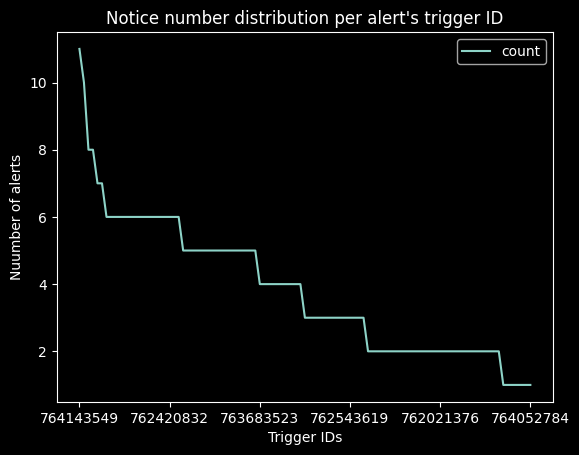

In [12]:
notices_df["tid"].value_counts().plot(kind="line")
plt.title("Notice number distribution per alert's trigger ID")
plt.ylabel("Nuumber of alerts")
plt.xlabel("Trigger IDs")
plt.legend()
plt.show()

In [13]:
notices_df["tid"].value_counts().describe()

count    101.000000
mean       3.831683
std        2.035040
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       11.000000
Name: count, dtype: float64

Our sample consists of 101 notices. On average, each alert results in about 4 notices. In our small sample there have been alerts with up to 10 notices. 

Let's look to how many notice per topic we got.

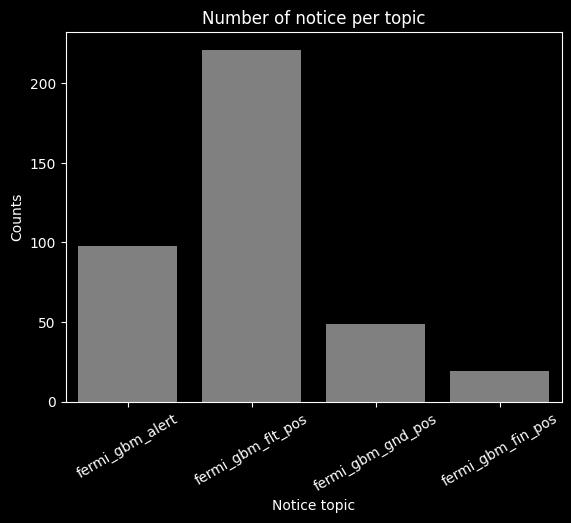

In [14]:
sns.barplot(notices_df["topic"].value_counts(), color="grey")
plt.title("Number of notice per topic")
plt.ylabel("Counts")
plt.xlabel("Notice topic")
plt.xticks(rotation=30)
plt.show()

The `fermi_gbm_flt_pos` topic is clearly the spammiest of the bunch. Only half of the ground position notice results in a final position.

In [17]:
notices_df["notice_time"].describe()

count                              387
mean     2025-03-04 23:02:12.772609792
min                2025-02-17 23:15:42
25%                2025-02-22 23:19:21
50%                2025-03-02 13:47:11
75%                2025-03-14 04:16:16
max                2025-03-26 13:24:43
Name: notice_time, dtype: object

The oldetst notice in the dataset is from 2025-02-17.

### Distribution of notice delay since first alert

We visualize the distribution of the delays arranging per topic category:

In [18]:
BOX_PLOT_OPTIONS = {"hue":"topic", "palette":"rocket", "linecolor":"white"}

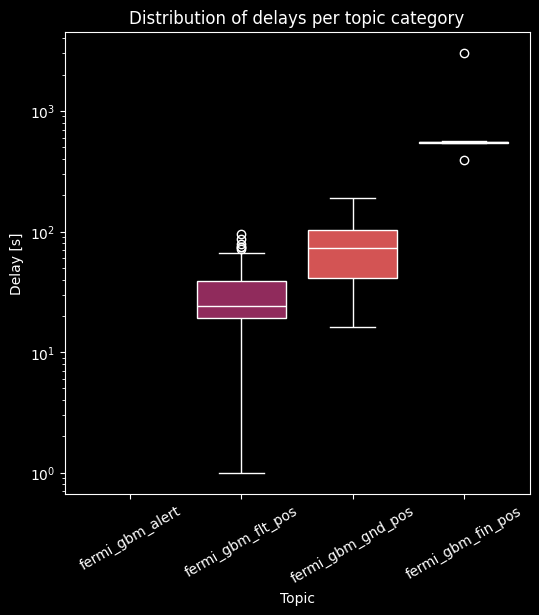

In [19]:
fig, ax = plt.subplots(figsize=(6., 6.))
sns.boxplot(data=notices_df, x="topic", y="delay", **BOX_PLOT_OPTIONS)
plt.title("Distribution of delays per topic category")
plt.ylabel("Delay [s]")
plt.xlabel("Topic")
plt.xticks(rotation=30)
plt.semilogy()
plt.show()

In [20]:
notices_df.groupby("topic", observed=True)["delay"].describe()

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
fermi_gbm_alert,98.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
fermi_gbm_flt_pos,221.0,29.126697,16.798600,1.0,19.0,24.0,39.0,95.0
fermi_gbm_gnd_pos,49.0,72.734694,37.303248,16.0,41.0,73.0,102.0,191.0
fermi_gbm_fin_pos,19.0,586.473684,629.484919,0.0,541.0,551.0,553.5,3045.0


From the results above we see that:
* Half of the flight position notices came beteen 20 and 40 seconds from the first alert. The earliest flight position notice are available one second after the alert already. The latest flight position alert notice came about 100s from the initial alert.
* Half of the ground position notices came between 40 and 100 seconds from the first alert. The  earliest ground position alert are available after ten seconds, and the latest come after 3 minutes or so.
* The distribution of the delays of notices from the "final position" topic is peculiar. Almost all notices come over an interval of 12 s, starting from +541s from the first alert. A few final position have no corresponding initial alert. Maybe these were subthreshold events that were later confirmed by human inspection of the data. There is a large outlier: a final position notice came 3045 seconds after the initial alert. Maybe a correction upon further investigation?

### Localization error

We study the localization error as a function of a notice delay and of the notice's topic. We start from distributions.

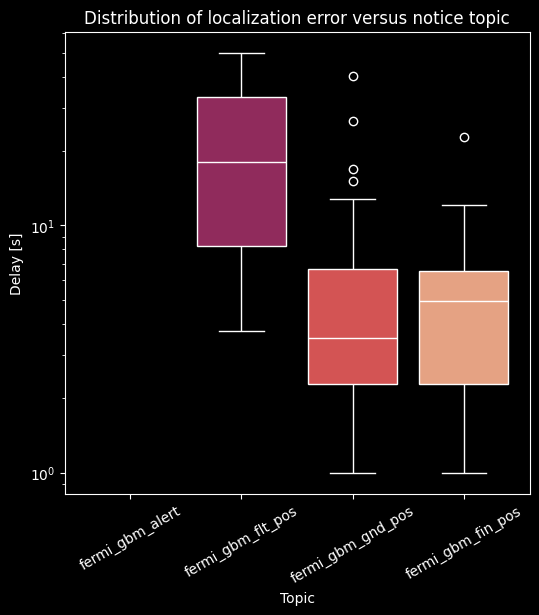

In [21]:
fig, ax = plt.subplots(figsize=(6., 6.))
sns.boxplot(data=notices_df, x="topic", y="err", **BOX_PLOT_OPTIONS)
plt.title("Distribution of localization error versus notice topic")
plt.ylabel("Delay [s]")
plt.xlabel("Topic")
plt.xticks(rotation=30)
plt.semilogy()
plt.show()

In [22]:
notices_df.groupby("topic", observed=True)["err"].describe()

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
fermi_gbm_alert,98.0,0.000000,0.000000,0.00,0.0000,0.0000,0.00,0.00
fermi_gbm_flt_pos,221.0,22.655430,15.881212,3.75,8.2667,18.0167,33.05,50.00
fermi_gbm_gnd_pos,49.0,5.901224,6.936455,1.00,2.2900,3.5200,6.66,40.34
fermi_gbm_fin_pos,19.0,5.772105,5.192470,1.00,2.2800,4.9600,6.57,22.86


While the flight position localization error is all over the place, it seems that the distribution of final and ground position notice localization are somewhat similiar. Half of the localization errors from ground or final position notices is between 2.2 and 6.6 degrees, which is decent. Also it's worthy to not how many of the outliers in ground position get eventually solved by the time a final position comes by. Alerts have localization errors always set to 0.0.

We investigate the dependence of the localization error from the notice's delay. First we plot the localization error versus the delay. We connect notices with the same trigger ID with lines.

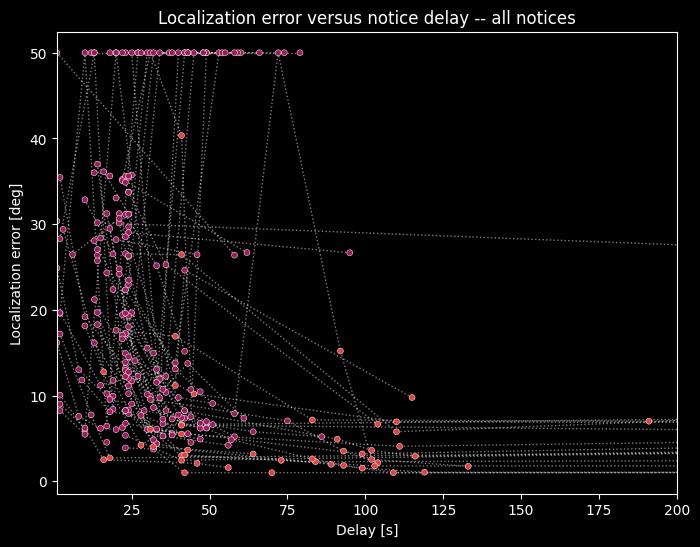

In [23]:
# we filter out alerts
_df = notices_df[notices_df["topic"] != "fermi_gbm_alert"]
mono_palette = sns.light_palette("white", n_colors=len(_df["tid"].unique()), as_cmap=False)

fig, ax = plt.subplots(figsize=(8., 6.))
sns.lineplot(data=_df, x='delay', y='err', hue='tid', marker="", linestyle="dotted", linewidth=1, palette=mono_palette, alpha=0.5, zorder=-1, ax=ax)
sns.scatterplot(data=_df, x='delay', y='err', hue='topic', marker="o", size=3, palette="rocket", ax=ax)
plt.legend([], [], frameon=False)
plt.title("Localization error versus notice delay -- all notices")
plt.ylabel("Localization error [deg]")
plt.xlabel("Delay [s]")
plt.xlim(1, 200)
plt.show()

We have two class off events:
1. alerts which get a number of flight position notice, but are filtered out (the localization error goes up to 50deg and never goes back) in the first 100 seconds. Likely false positives or transients of non-astrophysical nature?
2. alerts whose localization error drops exponentially and eventually result in ground position or final position notices.

Let's filter out all events which never get a ground position notice. Note the logarithmic scale.

In [24]:
tid_gnd_pos = _df[_df["topic"] == "fermi_gbm_gnd_pos"]["tid"].unique()
_df = _df[_df["tid"].isin(tid_gnd_pos)]

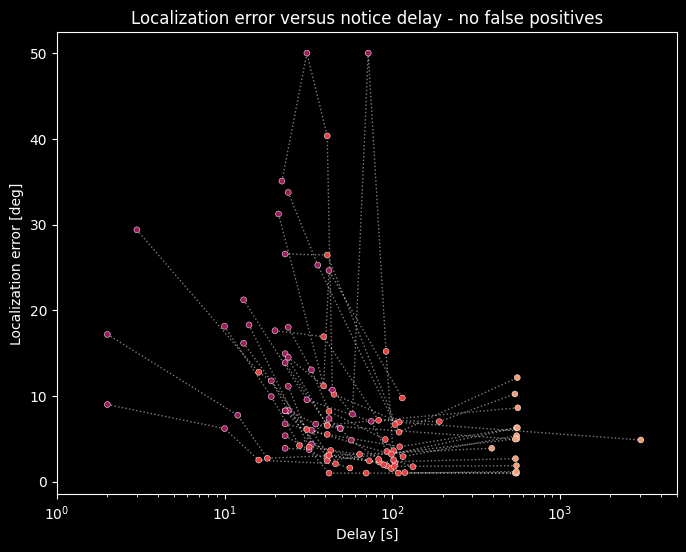

In [25]:
mono_palette = sns.light_palette("white", n_colors=len(_df["tid"].unique()), as_cmap=False)

fig, ax = plt.subplots(figsize=(8., 6.))
sns.lineplot(data=_df, x='delay', y='err', hue='tid', marker="", linestyle="dotted", linewidth=1, palette=mono_palette, alpha=0.5, zorder=-1, ax=ax)
sns.scatterplot(data=_df, x='delay', y='err', hue='topic', marker="o", size=3, palette="rocket", ax=ax)
plt.legend([], [], frameon=False)
plt.title("Localization error versus notice delay - no false positives")
plt.ylabel("Localization error [deg]")
plt.xlabel("Delay [s]")
plt.xlim(1, 5000)
plt.semilogx()
plt.show()

From this plot we can see:
* most (all?) alerts gets at least one subsequent flight position notice.
* Some of the alerts gets a ground position notice.
* An even smaller fraction of alert are completed with final position notice.

However it would be useful to quantify these frequencies. We do so in the next table and find that, if event which never get a ground position are indeed false positives, ~79% of the trigger ID does not result in an GRB event. 

In [26]:
topic_counts = notices_df.groupby('topic', observed=True)['tid'].nunique() / len(notices_df["tid"].unique())
topic_counts

topic
fermi_gbm_alert      0.970297
fermi_gbm_flt_pos    0.930693
fermi_gbm_gnd_pos    0.217822
fermi_gbm_fin_pos    0.188119
Name: tid, dtype: float64

### Is this trigger from a GRB?
#### Event class

But I feel like this is not enough, what we truly need is a table with TID index and a boolean column 'is_grb'. Seems obvious, but how the hell do we get this?

Ok so looking around I found the GBM [socket packet definition document](https://gcn.gsfc.nasa.gov/sock_pkt_def_doc.html). For flight position notices I found this very interesting bit:

```
[23] The "most_likely" field contains two values (2 shorts into the 1 long).
The least significant two bytes contains an the index value identifying
the source_object class of this event (eg GRB, solar flare, electron precip, etc).
The most significant two bytes contain the probability (ie confidence level) that
this class assignment is correct.  The range of the probability is 0.0 to 1.0;
and the units are in centi-probability (ie prob*100).
CLASS TABLE:
    //  Classes 0 to 3 are "single classes": the probabilities of these
    //  will be either 0 or 1, never an in between value.
    0  ERROR                - ????????????precise wording needed!!!!!!
    1  UNRELIABLE_LOCATION  - ????????????precise wording needed!!!!!!
    2  LOCAL_PARTICLES      - Local particles, equal rates in opposite detectors
    3  BELOW_HORIZON        - Distant particles, assumed to come from the horizon
    //  The remaining classes have probabilities calculated
    //  from Bayes Theorem: any value from 0.0 to 1.0 is possible.
    4  GRB                  - For bursts with good localizations
    5  GENERIC_SGR          - This is any SGR (except 1806-20)
    6  GENERIC_TRANSIENT    - Any astrophysical transient not included elsewhere
    7  DISTANT_PARTICLES    - Particles at a distance
    8  SOLAR_FLARE          - This is a Solar Flare event
    9  CYG_X1               - This trigger was caused by a CygX1 fluctuation
    10 SGR_1806_20          - This trigger came from SGR 1806-20
    11 GROJ_0422_32         - This trigger came from GRO J0422-32
    12-18  undefined        - (spares for future use)
    19 TGF                  - Terrestial Gamma Flashes

[24] The "2most_likely" field contains two values (2 shorts into the 1 long).
The least significant two bytes contains an the index value identifying
the second-most-likely source_object class of this event.
The most significant two bytes contain the probability (ie confidence level) that
this class assignment is correct.  The range of the probability is 0.0 to 1.0;
and the units are in centi-probability (ie prob*100).
The Class Table is the same as above.
```

We can indeed access these fields:

In [27]:
import random
random.seed(1)
from voeinfo import _get_param

# selects one flt pos at random
random_flt = random.choice(notices_df[notices_df["topic"] == "fermi_gbm_flt_pos"]["filename"].values)
print(f"Selected flight position notice '{random_flt}'")
notice = parse_notice(NOTICES_PATH / random_flt)

Selected flight position notice 'voe_fermi_gbm_flt_pos_5503.xml'


In [28]:
eclass = _get_param(notice, "What", "Most_Likely_Index")["@value"]
eprob = _get_param(notice, "What", "Most_Likely_Prob")["@value"]
print(f"File {random_flt} Most likely class is {eclass} (probability = {eprob})")

File voe_fermi_gbm_flt_pos_5503.xml Most likely class is 4 (probability = 91)


So let's define a function that will parse this parameter so that we can check how many of our flight position notice are from GRBs, and compare this number to the number of ground and final position.

In [29]:
from enum import Enum


class SourceClass(Enum):
    ERROR = 0
    UNRELIABLE_LOCATION = 1
    LOCAL_PARTICLES = 2
    BELOW_HORIZON = 3
    GRB = 4
    GENERIC_SGR = 5
    GENERIC_TRANSIENT = 6
    DISTANT_PARTICLES = 7
    SOLAR_FLARE =8
    CYG_X1 = 9
    SGR_1806_20 =10
    GROJ_0422_32 = 11
    TGF = 19


def mostlikely(notice: dict) -> tuple[int, float]:
    """
    Usage:
        These data are only available for flight position alerts.
    """
    return (
        SourceClass(int(_get_param(notice, "What", "Most_Likely_Index")["@value"])).name, 
        float(_get_param(notice, "What", "Most_Likely_Prob")["@value"]), 
    )

Let's add these information to our notice table and plot it.

In [30]:
mostlikelys = [mostlikely(n) if topic(fname) == "fermi_gbm_flt_pos" else (None, None) for fname, n in zip(filenames, notices)]
eclass, eprob = zip(*mostlikelys)
notices_df["event_class"] = eclass
notices_df["event_prob"] = eprob

notices_df

,filename,topic,tid,notice_time,obs_time,ra,dec,err,delay,event_class,event_prob
0,voe_fermi_gbm_flt_pos_5523.xml,fermi_gbm_flt_pos,762339644,2025-02-27 09:01:07,2025-02-27 09:00:39.170000+00:00,92.4833,43.4667,35.2333,22,TGF,100.0
1,voe_fermi_gbm_flt_pos_5537.xml,fermi_gbm_flt_pos,762420832,2025-02-28 07:35:19,2025-02-28 07:33:47.800000+00:00,67.9667,67.1167,5.2000,86,BELOW_HORIZON,100.0
2,voe_fermi_gbm_flt_pos_5531.xml,fermi_gbm_flt_pos,762414828,2025-02-28 05:54:19,2025-02-28 05:53:43.140000+00:00,42.0000,76.2333,6.7167,35,BELOW_HORIZON,100.0
3,voe_fermi_gbm_flt_pos_5587.xml,fermi_gbm_flt_pos,763594063,2025-03-13 21:28:10,2025-03-13 21:27:38.850000+00:00,232.4000,-33.5000,50.0000,30,UNRELIABLE_LOCATION,100.0
4,voe_fermi_gbm_alert_2729.xml,fermi_gbm_alert,764313931,2025-03-22 05:25:37,2025-03-22 05:25:26.380000+00:00,0.0000,0.0000,0.0000,0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
382,voe_fermi_gbm_alert_2648.xml,fermi_gbm_alert,761688783,2025-02-19 20:13:09,2025-02-19 20:12:58.480000+00:00,0.0000,0.0000,0.0000,0,None,NaN
383,voe_fermi_gbm_alert_2691.xml,fermi_gbm_alert,762882578,2025-03-05 15:49:40,2025-03-05 15:49:33.900000+00:00,0.0000,0.0000,0.0000,0,None,NaN
384,voe_fermi_gbm_flt_pos_5548.xml,fermi_gbm_flt_pos,762868077,2025-03-05 11:48:30,2025-03-05 11:47:52.550000+00:00,323.4667,-10.9000,14.9500,32,BELOW_HORIZON,100.0
385,voe_fermi_gbm_flt_pos_5609.xml,fermi_gbm_flt_pos,764109483,2025-03-19 20:38:29,2025-03-19 20:37:58.800000+00:00,355.4500,-6.2000,36.1167,16,UNRELIABLE_LOCATION,100.0


In [31]:
# filter notices not in the flight position topic
_df = notices_df[notices_df["topic"] == "fermi_gbm_flt_pos"]

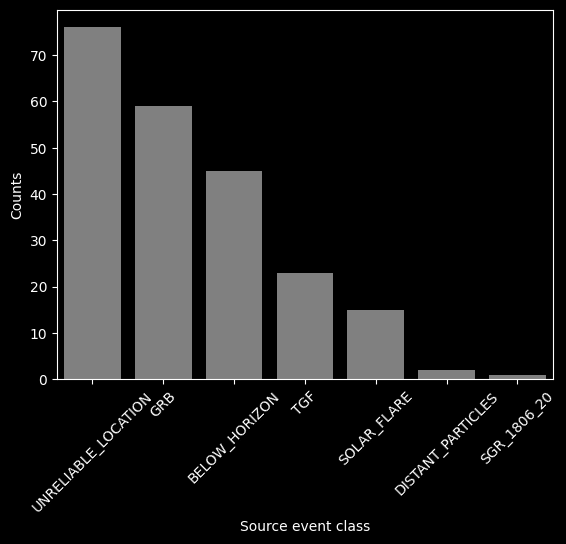

In [32]:
sns.barplot(_df["event_class"].value_counts(), color="grey")
plt.xticks(rotation=45)
plt.xlabel("Source event class")
plt.ylabel("Counts")
plt.show()

#### Retractions and temporal coincidence

NOTE: this turned out to be less interesting than it seems, at least on this dataset. Can skip for the moment.

Let's see what we can get out from ground position alerts. I have found another interesting entry in the docuemntation for this class of notices:

```
[18] The "soln_status" (aka trigger_id) field contains (a) flag bits on the type of solution
that was found in the on-board image and about whether it matches anything in the
on-board source catalog, and (b) flag bits that are assigned in the GCN ground-processing.
These bits will be determined largely (but not completely) by the ClassID in the Most_Likely fields.
The bit packing of the "soln_status" entry in the packet is:
BitNum  F-v-G  Item_name      Description
------  ----   ---------      -----------
0        G     LAT_FOV        In the LAT_FoV
1        G     Hi_E           GBM_hiE_inten_>_some_threshold
2-4      -     spare          spares for future use
5        G     def_not_grb    0=No or 1=Yes, it is definitely not a GRB (bad label; its really a Retraction)
6-11     -     spare          spares for future use
12       G     blk_cat_src    0=No or 1=Yes, it is in the catalog of sources to be blocked (internal use only)
13-25    -     spare          spares for future use
26-27    -     l-v-s          2 bits: 0=Undef,1=ShortGRB,2=LongGRB,3=not_used
28       G     spatial_coinc  0=No or 1=Yes, there was a spatial coincidence with another event
29       G     temporal_coinc 0=No or 1=Yes, there was a temporal coincidence with another event
30       G     test_submit    0=No or 1=Yes, this is a test submission (internal use only)
31       -     spare          spare for future use
The columns are:  "BitNum" is the 2^N location within the 4-byte word; "F-v-G" is Flight-assigned vs
Ground-assigned;  "Item_name" is the short-description name of the quantity;  and
"Description" is the longer description of the quantity.
```

Here in particular the `def_not_grb` (retraction, check description carefully) and `temporal_coinc` flags could be of interest.

In [33]:
random.seed(0)

random_gnd = random.choice(notices_df[notices_df["topic"] == "fermi_gbm_gnd_pos"]["filename"].values)
print(f"Selected ground position notice '{random_gnd}'")
notice = parse_notice(NOTICES_PATH / random_gnd)

Selected ground position notice 'voe_fermi_gbm_gnd_pos_1038.xml'


In [34]:
from typing import Literal

# this is different from `_get_param`. now that i keep working at this
# i realize these utility function shall be more general.
def __get_param(
    notice: dict,
    name: str
):
    param_list = notice["Param"]
    for param in param_list:
        if param["@name"] == name:
            return param
    raise ValueError(f"Missing param '{name}'.")

    
def _get_group(
    notice: dict,
    name: str
):
    group_list = notice["Group"]
    for group in group_list:
        if group["@name"] == name:
            return group
    raise ValueError(f"Missing group '{name}'.")


def retraction(notice: dict) -> bool:
    return bool(0 if __get_param(_get_group(notice["What"], "Trigger_ID"), "Def_NOT_a_GRB")["@value"] == "false" else 1)

def temporal_coinc(notice: dict) -> bool:
    return bool(0 if __get_param(_get_group(notice["What"], "Trigger_ID"), "Temporal_Prox_Match")["@value"] == "false" else 1)

We will not add retractions to our table because I checked that all the ground position we got are not retractions.. It seems there are not any other interesting flags to check, at least for the `gnd_pos` e `fin_pos` type notices. There are a few more topics which could be worth to check but maybe it's best to reserve those to a second analysis. So let's try to get the most out of what we got. 


Let's check if alerts with final position always correspond to flight position within the GRB event class.

In [35]:
tids_fin_pos = notices_df[notices_df["topic"] == "fermi_gbm_fin_pos"]["tid"].unique()
_df = notices_df[notices_df["tid"].isin(tids_fin_pos)]
_df = _df[_df["topic"] == "fermi_gbm_flt_pos"]
print(f"Fraction of final position notice whose flight position event class is GRB = {100 * len(_df[_df['event_class'] == 'GRB']) / len(_df):.1f} %")

Fraction of final position notice whose flight position event class is GRB = 100.0 %


It seems so. We don't get the same result for ground positions.

In [36]:
tids_gnd_pos = notices_df[notices_df["topic"] == "fermi_gbm_gnd_pos"]["tid"].unique()
_df = notices_df[notices_df["tid"].isin(tids_gnd_pos)]
_df = _df[_df["topic"] == "fermi_gbm_flt_pos"]
print(f"Fraction of ground position notice whose flight position event class is GRB = {100 * len(_df[_df['event_class'] == 'GRB']) / len(_df):.1f} %")

Fraction of ground position notice whose flight position event class is GRB = 81.8 %


However since ground positions and flight positions are in a one to many relation is it worth to double check this number.. Let's look only at the last flight position before the first ground position.

In [37]:
last_event_class_before_gnd = []
for tid in tids_gnd_pos:
    earliest_gnd_notice_time = min(
        notices_df[
        (notices_df["tid"] == tid) & 
        (notices_df["topic"] == "fermi_gbm_gnd_pos") 
        ]["notice_time"]
    )
    last_event_class_before_gnd.append(
        notices_df[
        (notices_df["tid"] == tid) & 
        (notices_df["topic"] == "fermi_gbm_flt_pos") & 
        (notices_df["notice_time"] <= earliest_gnd_notice_time)
        ].sort_values("notice_time").iloc[-1]["event_class"]
    )
print(f"Fraction of ground position notice whose last flight position event class is GRB = {100 * len([*filter(lambda x: x == 'GRB', last_event_class_before_gnd)]) / len(last_event_class_before_gnd):.1f} %")

Fraction of ground position notice whose last flight position event class is GRB = 100.0 %


# Conclusion

1. We downloaded VOEvent position notices from the GCN Kafka stream. The oldest notice retrieved in this way is one month old.
2. We wrote a function for parsing XML VOEvent notices into Python dictionaries and a few helpers to extract useful information from these, such as localization, localization error, transients, source class, and so on.
3. We found that localization error improves rather fast within the first minutes from the first alert.
4. Ground position and final position alerts have similar localization error distribution. Ground position alerts are emitted in about 100 seconds from the first alert; final position can take up to hours.
5. All ground and final positions in our sample were emitted after flight position notices attributed to GRB. There are no ground or final position notices for other kinds of transients.